# **AI LAB 2023**
### A. Calderoni, A. Fabbricatore, S. Mancini, A. Pranzo, B. Zanini

## Experimental Background

**Definitions**

- Hypoxia: "depleted" oxygen levels in tissue culture flasks, i.e. about 2% oxygen
- Normoxia: “normal” oxygen levels in tissue culture flasks, i.e. about 20–21% oxygen

**Why is it important to study whether cells are hypoxia or normoxia?**

Cancer cells are cells which grow excessively and refuse to die, but rather keep increasing in number. Specifically, they require more oxygen than other "normal" cells but there are problems occuring when metastases occupy large areas as blood vessels are incapable of supplying sufficient oxygen to that area. The result is that cancer cells will adapt (become hypoxia cells) in order to survive under the harsher low oxygen conditions. Hypoxia cancer cells are much more aggressive and difficult to treat - a greater ability to distinguish them early on would allow, potentially, better treatment in response to the cancer.

**Data Experimental Design**

In our experiment, we grow certain cells in one environment with normal oxygen levels (21%) and other cells in an environment with lower oxygen levels (1% of oxygen). Then, using the Smart-Seq and Drop-Seq technologies for single-cell RNA sequencing, we sequenced each and every cell. Both of these sequencing approaches were used on the HCC1086 and MCF7 cell lines. Particularly they are cell lines corresponding to different breast cancers -  ASCC and adenocarcinoma1 respectively.

**Data Structure**

There are two main types of files: data and metadata.

Data:
The raw unfiltered data used is organised in .txt files whereby the naming conventions is the following: {cell_type}/{sequencing_technique}/{data_type}. They are made in such a way that cell names are the columns and genes are the rows with each value in the dataframe being the "amount" of that gene present in the cell.

Metadata:
The metadata used is organised in .tsv files whereby the naming conventions is the following: {cell_type}/{sequencing_technique}. Each row in the dataframe represents a cell and each column represents a general attribute about it - with a relevant one being our target variable "Pos	Condition".

**Aim of our Project**

Our goal is to develop a solid predictor from data that can determine whether a cell was living in a hypoxic or normal environment based on its gene expression.

**Important**

Numerically, hypoxia will be represented as 0 and normoxia as 1.


In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis, skew
from sklearn.decomposition import PCA
from fix_data import add_label_T
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

## Exploratory Data Analysis and Cleaning

In [92]:
unfilt_hcc_smarts = pd.read_csv("data/smartSeq/HCC1806_SmartS_Unfiltered_Data.txt", sep = " ")
meta_hcc_smarts = pd.read_table("data/smartSeq/HCC1806_SmartS_MetaData.tsv")

unfilt_mcf_smarts = pd.read_csv("data/smartSeq/MCF7_SmartS_Unfiltered_Data.txt", sep = " ")
meta_mcf_smarts = pd.read_table("data/smartSeq/MCF7_SmartS_MetaData.tsv")

As aforementioned, the metadata file contains general information about each cell, as can be seen in the code below. With the *Condition* column being our target for the overall project.

In [93]:
meta_hcc_smarts

,Filename,Cell Line,PCR Plate,Pos,Condition,Hours,Cell name,PreprocessingTag,ProcessingComments
0,output.STAR.PCRPlate1A10_Normoxia_S123_Aligned...,HCC1806,1,A10,Normo,24,S123,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
1,output.STAR.PCRPlate1A12_Normoxia_S26_Aligned....,HCC1806,1,A12,Normo,24,S26,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
2,output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.so...,HCC1806,1,A1,Hypo,24,S97,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
3,output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.s...,HCC1806,1,A2,Hypo,24,S104,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
4,output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sor...,HCC1806,1,A3,Hypo,24,S4,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
...,...,...,...,...,...,...,...,...,...
238,output.STAR.PCRPlate4H10_Normoxia_S210_Aligned...,HCC1806,4,H10,Normo,24,S210,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
239,output.STAR.PCRPlate4H11_Normoxia_S214_Aligned...,HCC1806,4,H11,Normo,24,S214,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
240,output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.s...,HCC1806,4,H2,Hypo,24,S199,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"
241,output.STAR.PCRPlate4H7_Normoxia_S205_Aligned....,HCC1806,4,H7,Normo,24,S205,Aligned.sortedByCoord.out.bam,"STAR,FeatureCounts"


Moreover, as already discussed in the introduction, we then have the unfiltered dataset which contains the different cells as its columns and the count of each gene (row) respectively.

In [94]:
print(f"The dimension of the unfiltered hcc1806 dataset is: {unfilt_hcc_smarts.shape}")
print(f"The dimension of the unfiltered mcf7 dataset is: {unfilt_mcf_smarts.shape}")
unfilt_mcf_smarts

The dimension of the unfiltered hcc1806 dataset is: (23396, 243)
The dimension of the unfiltered mcf7 dataset is: (22934, 383)


,output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam,output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam,output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam,output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam,output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam,output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam,output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam,output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord.out.bam,output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord.out.bam,output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord.out.bam,...,output.STAR.4_H14_Hypo_S383_Aligned.sortedByCoord.out.bam,output.STAR.4_H1_Norm_S355_Aligned.sortedByCoord.out.bam,output.STAR.4_H2_Norm_S356_Aligned.sortedByCoord.out.bam,output.STAR.4_H3_Norm_S357_Aligned.sortedByCoord.out.bam,output.STAR.4_H4_Norm_S358_Aligned.sortedByCoord.out.bam,output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam,output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam,output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam,output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam,output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam
WASH7P,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
MIR6859-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WASH9P,1,0,0,0,0,1,10,1,0,0,...,1,1,0,0,0,0,1,1,4,5
OR4F29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
MTND1P23,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-TE,4,0,0,0,3,3,0,0,14,1,...,0,4,12,4,0,1,6,0,7,4
MT-CYB,270,1,76,66,727,2717,9326,3253,7949,30,...,239,3795,12761,2263,1368,570,3477,349,2184,1149
MT-TT,0,0,0,0,0,1,1,1,4,0,...,0,7,4,2,0,0,3,0,2,2
MT-TP,5,0,0,1,0,1,1,4,2,0,...,0,14,56,11,2,0,7,2,28,11


It is important to check whether all the values in the datasets are of the same type, as if they aren't they'd require adaptation.

In [95]:
print(f"The datatypes in the hcc1806 dataset are: {str(set([i for i in unfilt_hcc_smarts.T.dtypes]))[8:-3]}")
print(f"The datatypes in the mcf7 dataset are: {str(set([i for i in unfilt_mcf_smarts.T.dtypes]))[8:-3]}")
print("Hence, they are all of the same type.")

The datatypes in the hcc1806 dataset are: int64
The datatypes in the mcf7 dataset are: int64
Hence, they are all of the same type.


Let's also run a .describe() of the datasets to get a more general picture.

In [96]:
print(unfilt_mcf_smarts.describe())
print(unfilt_hcc_smarts.describe())

       output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000          
mean                                           40.817651          
std                                           465.709940          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                            17.000000          
max                                         46744.000000          

       output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000          
mean                                            0.012253          
std                                             0.207726          
min                                             0.000000          
25%                                             0.000000     

It's interesting as it seems that some columns have an average gene count of 0... we will explore this later and address it.

We now check for null values, which would have to be dealt with in the circumstance that they were present.

In [97]:
print(f"The number of null values in the hcc1806 dataset are: {unfilt_hcc_smarts.isnull().sum(axis = 1).sum(axis = 0)}")
print(f"The number of null values in the mcf7 dataset are: {unfilt_mcf_smarts.isnull().sum(axis = 1).sum(axis = 0)}")

The number of null values in the hcc1806 dataset are: 0
The number of null values in the mcf7 dataset are: 0


Now let's look at the correlation between cells. It may be useful in cutting down the overall size of the dataframe and moreover better understand its structure.

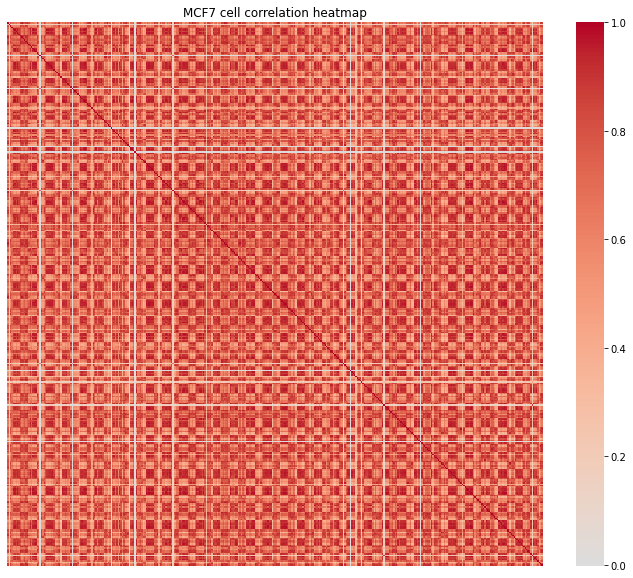

In [98]:
plt.figure(figsize=(12,10))
plt.title("MCF7 cell correlation heatmap")
corr = unfilt_mcf_smarts.corr()
midpoint = (corr.values.max() - corr.values.min()) /2 + corr.values.min()

sns.heatmap(corr,cmap="coolwarm", center=0, yticklabels=False , xticklabels=False);

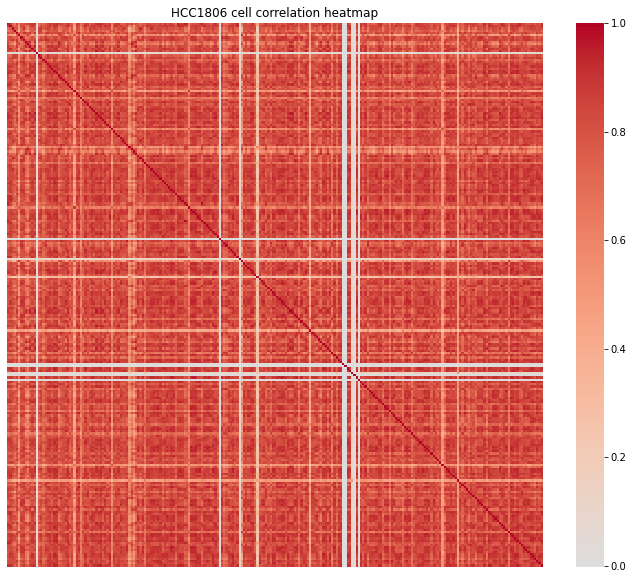

In [99]:
plt.figure(figsize=(12,10))
plt.title("HCC1806 cell correlation heatmap")
corr = unfilt_hcc_smarts.corr()
midpoint = (corr.values.max() - corr.values.min()) /2 + corr.values.min()

sns.heatmap(corr,cmap="coolwarm", center=0, yticklabels=False , xticklabels=False);

Interestingly there are cells which have a correlation close to 0 with respect to all other cells (vertical and horizontal white lines), we will analyse them to try to understand why.

In [100]:
corr = unfilt_mcf_smarts.corr()
corr_matrix = pd.DataFrame(data=corr)
corr_matrix.head()

,output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam,output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam,output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam,output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam,output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam,output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam,output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam,output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord.out.bam,output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord.out.bam,output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord.out.bam,...,output.STAR.4_H14_Hypo_S383_Aligned.sortedByCoord.out.bam,output.STAR.4_H1_Norm_S355_Aligned.sortedByCoord.out.bam,output.STAR.4_H2_Norm_S356_Aligned.sortedByCoord.out.bam,output.STAR.4_H3_Norm_S357_Aligned.sortedByCoord.out.bam,output.STAR.4_H4_Norm_S358_Aligned.sortedByCoord.out.bam,output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam,output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam,output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam,output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam,output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam,1.000000,0.292568,0.808329,0.697870,0.721242,0.642948,0.709258,0.617521,0.618802,0.900562,...,0.838974,0.521685,0.163054,0.560572,0.554862,0.570941,0.668708,0.457658,0.890291,0.874445
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam,0.292568,1.000000,0.146217,0.182917,0.212992,0.171827,0.222140,0.148963,0.171648,0.220787,...,0.196892,0.136905,0.116034,0.145569,0.135938,0.110866,0.141656,0.137021,0.254233,0.199633
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam,0.808329,0.146217,1.000000,0.646251,0.600347,0.588118,0.635104,0.576847,0.604278,0.844294,...,0.802609,0.540563,0.132710,0.547429,0.576650,0.607403,0.693280,0.609518,0.843927,0.851434
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam,0.697870,0.182917,0.646251,1.000000,0.715393,0.692161,0.780425,0.692138,0.760664,0.775325,...,0.736469,0.706532,0.346201,0.662226,0.759793,0.689692,0.783976,0.451558,0.667993,0.719326
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam,0.721242,0.212992,0.600347,0.715393,1.000000,0.955126,0.895659,0.943620,0.869165,0.838086,...,0.679765,0.823229,0.172095,0.902144,0.865805,0.883352,0.698426,0.328031,0.566170,0.667335


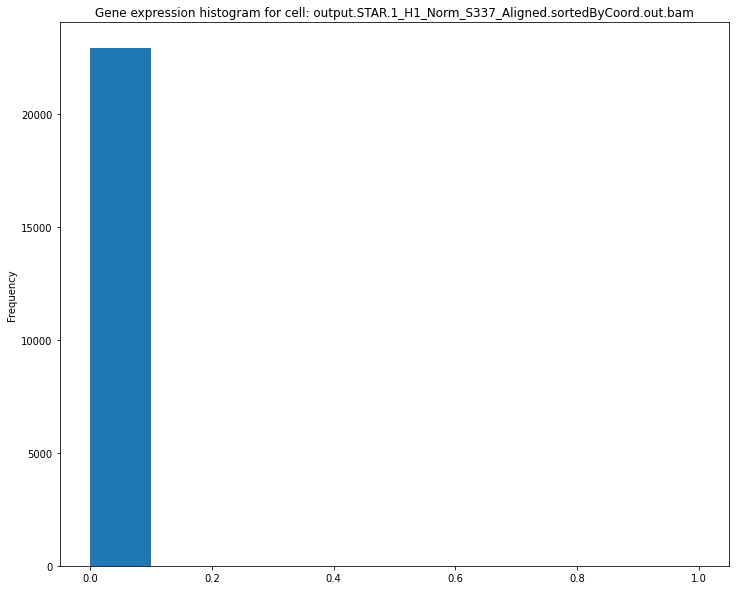

In [101]:
#let's find the cell with the lowest correlation with respect to all other cells and plot its gene structure.
col_sums = corr_matrix.sum()
min_col = col_sums.idxmin()
plt.figure(figsize=(12,10))
plt.hist(unfilt_mcf_smarts.loc[:,min_col])
plt.title(f"Gene expression histogram for cell: {min_col}");
plt.ylabel("Frequency");

As is evident in the histogram, the reason for why some cells are totally uncorrelated to others is that they have a gene count of 0 for all genes (or at least very close to 0 in the other cases). These cells will be removed during the filtering part.

In this project we will more so focus on genes as opposed to cells, and therefore understanding the correlations between genes could aid us in the construction of a model with better accuracy (as well as reducing redundancy by not including all the covariates which are highly correlated between each other).

Average correlation between cells:  0.3695789318416762
Minimum correlation between cells:  -0.2608421363166476 



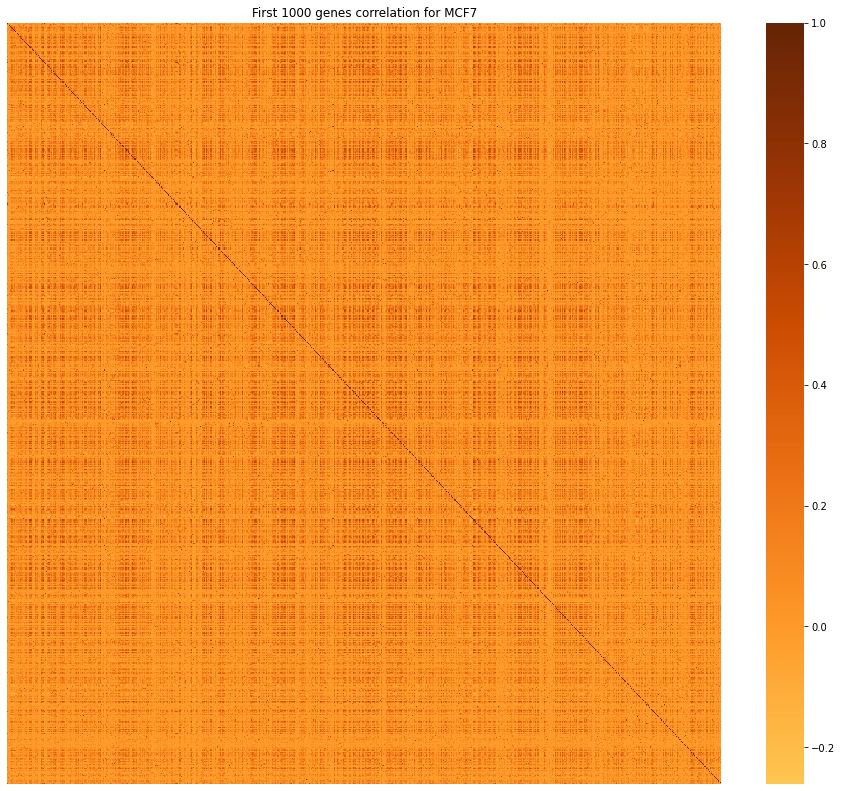

In [102]:
plt.figure(figsize=(16,14))
plt.title("First 1000 genes correlation for MCF7")
#df_small = df.iloc[:, :50]
#c= df_small.corr()
corr = unfilt_mcf_smarts.iloc[:1000,:].T.corr()
midpoint = (corr.values.max() - corr.values.min()) /2 + corr.values.min()
#sns.heatmap(c,cmap='coolwarm',annot=True, center=midpoint )
sns.heatmap(corr,cmap="YlOrBr", center=0, yticklabels=False , xticklabels=False)

print("Average correlation between cells: ", midpoint)
print("Minimum correlation between cells: ", corr.values.min(), "\n")

Sadly it seems as though no gene stands out with respect to its correlation with other genes. This could have been useful as the presence of highly important genes would have allowed substantial dimensionality reduction.

Let's now study the distribution of the data to better understand how to treat it when building our model at the end of the project.

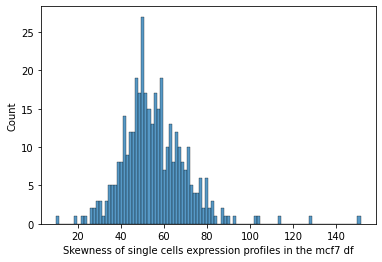

In [103]:
colN = np.shape(unfilt_mcf_smarts)[1]
colN
df_skew_cells = []
for i in range(colN) :     
     v_df = unfilt_mcf_smarts[unfilt_mcf_smarts.columns[i]]
     df_skew_cells += [skew(v_df)]   
  #  df_skew_cells += [df[cnames[i]].skew()]
df_skew_cells
sns.histplot(df_skew_cells,bins=100)
plt.xlabel('Skewness of single cells expression profiles in the mcf7 df')
plt.show()

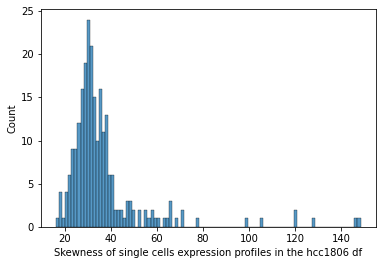

In [104]:
colN = np.shape(unfilt_hcc_smarts)[1]
colN
df_skew_cells = []
for i in range(colN) :     
     v_df = unfilt_hcc_smarts[unfilt_hcc_smarts.columns[i]]
     df_skew_cells += [skew(v_df)]   
  #  df_skew_cells += [df[cnames[i]].skew()]
df_skew_cells
sns.histplot(df_skew_cells,bins=100)
plt.xlabel('Skewness of single cells expression profiles in the hcc1806 df')
plt.show()

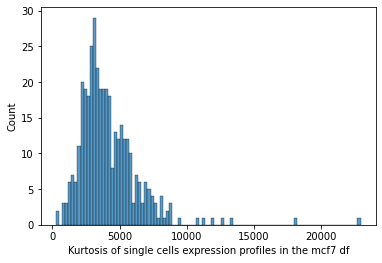

In [105]:
colN = np.shape(unfilt_mcf_smarts)[1]
colN
df_skew_cells = []
for i in range(colN) :     
     v_df = unfilt_mcf_smarts[unfilt_mcf_smarts.columns[i]]
     df_skew_cells += [kurtosis(v_df)]   
  #  df_skew_cells += [df[cnames[i]].skew()]
df_skew_cells
sns.histplot(df_skew_cells,bins=100)
plt.xlabel('Kurtosis of single cells expression profiles in the mcf7 df')
plt.show()

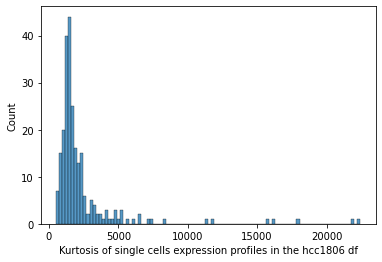

In [106]:
colN = np.shape(unfilt_hcc_smarts)[1]
colN
df_skew_cells = []
for i in range(colN) :     
     v_df = unfilt_hcc_smarts[unfilt_hcc_smarts.columns[i]]
     df_skew_cells += [kurtosis(v_df)]   
  #  df_skew_cells += [df[cnames[i]].skew()]
df_skew_cells
sns.histplot(df_skew_cells,bins=100)
plt.xlabel('Kurtosis of single cells expression profiles in the hcc1806 df')
plt.show()

In [107]:
hcc_skew = [skew(unfilt_hcc_smarts[i]) for i in unfilt_hcc_smarts.columns]
mcf_skew = [skew(unfilt_mcf_smarts[i]) for i in unfilt_mcf_smarts.columns]
hcc_kurtosis = [kurtosis(unfilt_hcc_smarts[i]) for i in unfilt_hcc_smarts.columns]
mcf_kurtosis = [kurtosis(unfilt_mcf_smarts[i]) for i in unfilt_mcf_smarts.columns]
print(f"The mean skewness in the HCC1806 cells is: {np.mean(hcc_skew)}")
print(f"The mean kurtosis in the HCC1806 cells is: {np.mean(hcc_kurtosis)}")
print(f"The mean skewness in the MCF7 cells is: {np.mean(mcf_skew)}")
print(f"The mean kurtosis in the MCF7 cells is: {np.mean(mcf_kurtosis)}")

The mean skewness in the HCC1806 cells is: 36.75112201656807
The mean kurtosis in the HCC1806 cells is: 2396.1365186183593
The mean skewness in the MCF7 cells is: 55.59958034753704
The mean kurtosis in the MCF7 cells is: 4164.854641341205


The above values of skewness and kurtosis for each dataframe highlight how the data is highly non-normal, skewed with heavy tails. When coupled with the fact that most cells have a count of 0 for most genes (but when they don't they can reach huge counts of 40000+) this suggests that the information is CONTAINED IN THE OUTLIERS. Therefore, the previous objective of removing them will be disregarded as it would make the data obsolete.

This argument can be further strengthened with violin plots.

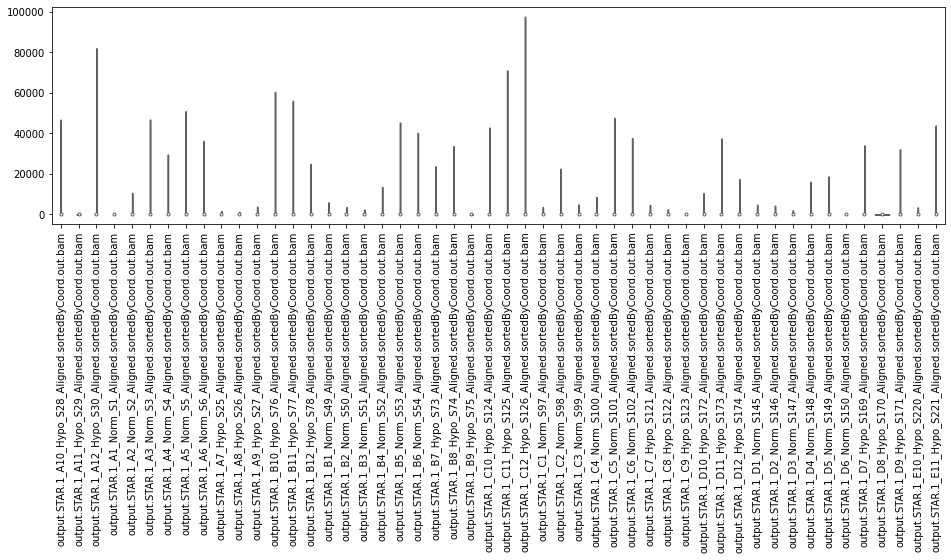

In [108]:
unfilt_mcf_smarts_small = unfilt_mcf_smarts.iloc[:, :50]
np.shape(unfilt_mcf_smarts_small)
plt.figure(figsize=(16,4))
plot=sns.violinplot(data=unfilt_mcf_smarts_small,palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.show()

Now let's remove outliers using a standard Interquartile Range approach.

In [109]:
Q1 = unfilt_mcf_smarts.quantile(0.25)
Q3 = unfilt_mcf_smarts.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam    17.0
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam     0.0
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam     5.0
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam       0.0
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam       7.0
                                                            ... 
output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam     9.0
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam    27.0
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam    30.0
output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam    38.0
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam    33.0
Length: 383, dtype: float64


In [110]:
unfilt_mcf_smarts_noOut = unfilt_mcf_smarts[~((unfilt_mcf_smarts < (Q1 - 1.5 * IQR)) |(unfilt_mcf_smarts > (Q3 + 1.5 * IQR))).any(axis=1)]
print(unfilt_mcf_smarts_noOut.shape)
unfilt_mcf_smarts_noOut.head(3)

(6435, 383)


,output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam,output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam,output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam,output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam,output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam,output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam,output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam,output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord.out.bam,output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord.out.bam,output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord.out.bam,...,output.STAR.4_H14_Hypo_S383_Aligned.sortedByCoord.out.bam,output.STAR.4_H1_Norm_S355_Aligned.sortedByCoord.out.bam,output.STAR.4_H2_Norm_S356_Aligned.sortedByCoord.out.bam,output.STAR.4_H3_Norm_S357_Aligned.sortedByCoord.out.bam,output.STAR.4_H4_Norm_S358_Aligned.sortedByCoord.out.bam,output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam,output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam,output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam,output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam,output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam
MIR6859-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CICP3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM87B,0,0,0,0,0,0,0,0,2,0,...,0,1,0,0,0,0,0,0,0,0


We can see how the above reduced the row size by around 16000 (a 72% reduction!).

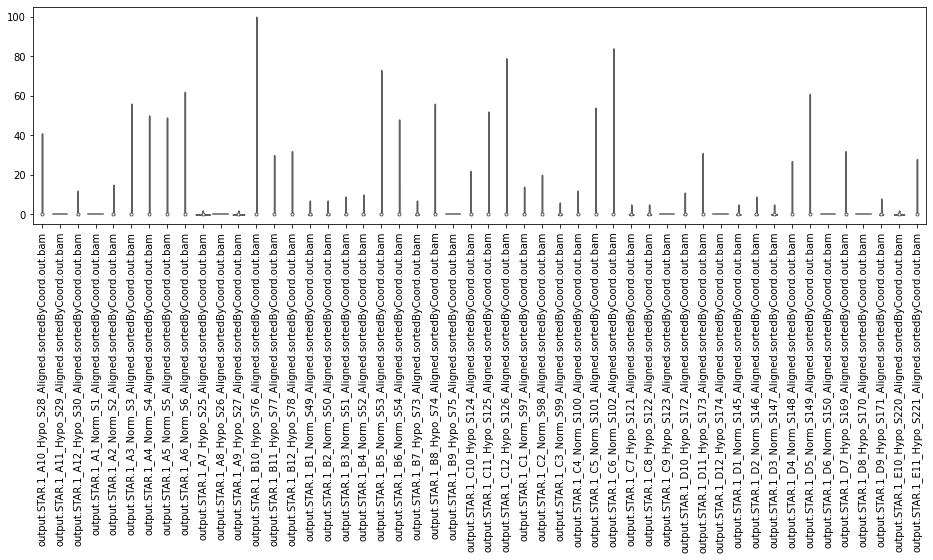

In [111]:
unfilt_mcf_smarts_small_noOut = unfilt_mcf_smarts_noOut.iloc[:, :50]
np.shape(unfilt_mcf_smarts_small_noOut)
plt.figure(figsize=(16,4))
plot=sns.violinplot(data=unfilt_mcf_smarts_small_noOut,palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.show()

As expected, they still don't look good as we have many zeros now. Simply removing outliers as expected did not work because the important information is contained in the non-zero terms.
This poses the question... how sparse is the data?

In [112]:
Q1 = unfilt_hcc_smarts.quantile(0.25)
Q3 = unfilt_hcc_smarts.quantile(0.75)
IQR = Q3 - Q1
unfilt_hcc_smarts_noOut = unfilt_hcc_smarts[~((unfilt_hcc_smarts < (Q1 - 1.5 * IQR)) |(unfilt_hcc_smarts > (Q3 + 1.5 * IQR))).any(axis=1)]

In [113]:
print(f"The sparsity in the HCC1806 df is: {round((unfilt_hcc_smarts == 0).sum().sum() / (unfilt_hcc_smarts.shape[0] * unfilt_hcc_smarts.shape[1]) * 100, 2)}%")
print(f"The sparsity in the HCC1806 df, without outliers, is: {round((unfilt_hcc_smarts_noOut == 0).sum().sum() / (unfilt_hcc_smarts_noOut.shape[0] * unfilt_hcc_smarts_noOut.shape[1]) * 100, 2)}%")
print(f"The sparsity in the MCF7 df is: {round((unfilt_mcf_smarts == 0).sum().sum() / (unfilt_mcf_smarts.shape[0] * unfilt_mcf_smarts.shape[1]) * 100, 2)}%")
print(f"The sparsity in the MCF7 df, without outliers, is: {round((unfilt_mcf_smarts_noOut == 0).sum().sum() / (unfilt_mcf_smarts_noOut.shape[0] * unfilt_mcf_smarts_noOut.shape[1]) * 100, 2)}%")


The sparsity in the HCC1806 df is: 55.85%
The sparsity in the HCC1806 df, without outliers, is: 86.73%
The sparsity in the MCF7 df is: 60.22%
The sparsity in the MCF7 df, without outliers, is: 95.49%


Evidently this is a very high value of sparsity which again reiterates our thesis that the important information of the dataset is contained in the outliers.

Moreover, since we have now understood that the high-zero value cell lines cannot be disregarded, we may at least attempt to fix the problem with regardes to the highly non-normal data. In order to do so, we will attempt using a log2 transformation in the data in the hope that it renders it more normalised. It is common to utilize log based 2 where +1 denotes a doubling of the feature abundance (in this case, gene expression) and -1 denotes a halving of the feature abundance/gene expression. The up-regulation and down-regulation of a gene in relation to a control are symmetrical when changes in the values are transformed this way.

In [114]:
hcc_smarts_one = unfilt_hcc_smarts + 1
hcc_smarts_log = hcc_smarts_one.apply(np.log2)

mcf_smarts_one = unfilt_mcf_smarts + 1
mcf_smarts_log = mcf_smarts_one.apply(np.log2)

We now check for kurtosis and skewness again to see how our data changed.

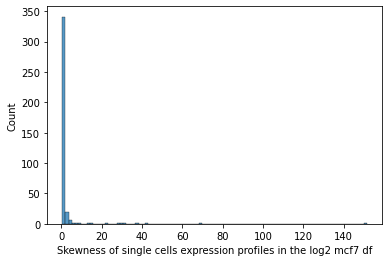

In [115]:
colN = np.shape(mcf_smarts_log)[1]
colN
df_skew_cells = []
for i in range(colN) :     
     v_df = mcf_smarts_log[mcf_smarts_log.columns[i]]
     df_skew_cells += [skew(v_df)]   
  #  df_skew_cells += [df[cnames[i]].skew()]
df_skew_cells
sns.histplot(df_skew_cells,bins=100)
plt.xlabel('Skewness of single cells expression profiles in the log2 mcf7 df')
plt.show()

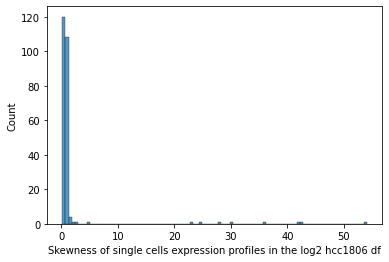

In [116]:
colN = np.shape(hcc_smarts_log)[1]
colN
df_skew_cells = []
for i in range(colN) :     
     v_df = hcc_smarts_log[hcc_smarts_log.columns[i]]
     df_skew_cells += [skew(v_df)]   
  #  df_skew_cells += [df[cnames[i]].skew()]
df_skew_cells
sns.histplot(df_skew_cells,bins=100)
plt.xlabel('Skewness of single cells expression profiles in the log2 hcc1806 df')
plt.show()

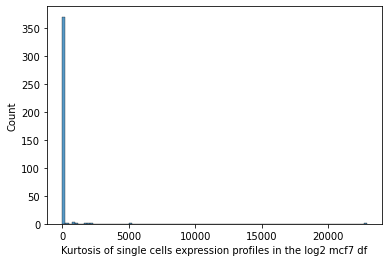

In [117]:
colN = np.shape(mcf_smarts_log)[1]
colN
df_skew_cells = []
for i in range(colN) :     
     v_df = mcf_smarts_log[mcf_smarts_log.columns[i]]
     df_skew_cells += [kurtosis(v_df)]   
  #  df_skew_cells += [df[cnames[i]].skew()]
df_skew_cells
sns.histplot(df_skew_cells,bins=100)
plt.xlabel('Kurtosis of single cells expression profiles in the log2 mcf7 df')
plt.show()

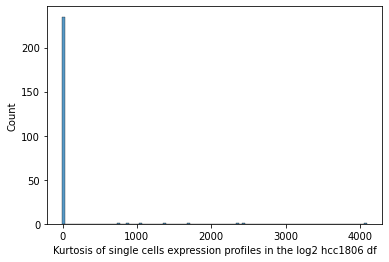

In [118]:
colN = np.shape(hcc_smarts_log)[1]
colN
df_skew_cells = []
for i in range(colN) :     
     v_df = hcc_smarts_log[hcc_smarts_log.columns[i]]
     df_skew_cells += [kurtosis(v_df)]   
  #  df_skew_cells += [df[cnames[i]].skew()]
df_skew_cells
sns.histplot(df_skew_cells,bins=100)
plt.xlabel('Kurtosis of single cells expression profiles in the log2 hcc1806 df')
plt.show()

When compared to the above graphs of kurtosis and skewness the data already looks much better. Let's now use a violinplot, like before, to see whether this transformation has resulted in an improvement or not.

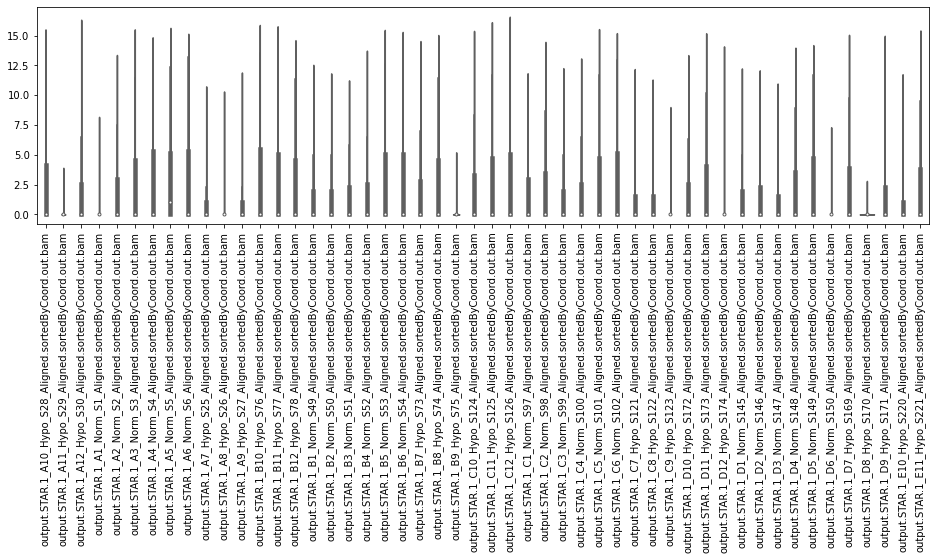

In [119]:
mcf_smarts_log_small = mcf_smarts_log.iloc[:, :50]
np.shape(mcf_smarts_log_small)
plt.figure(figsize=(16,4))
plot=sns.violinplot(data=mcf_smarts_log_small,palette="Set3",cut=0)
plt.setp(plot.get_xticklabels(), rotation=90)
plt.show()

As expected, the transformation has indeed helped us as shown by our violin plots (this is especially visible when compared to the previous version of them).

Finally before continuing, let's check for and remove duplicate rows in each dataframe... this could be the result of various reasons such as but not limited to redundancy in gene annotation, overlapping of gene annotation on the same region etc.

In [120]:
hcc_dup_unfilt = hcc_smarts_log[hcc_smarts_log.duplicated(keep=False)]
print(f"The number of duplicate rows in the HCC1806 dataframe is: {hcc_dup_unfilt.shape[0]}")
mcf_dup_unfilt = mcf_smarts_log[mcf_smarts_log.duplicated(keep=False)]
print(f"The number of duplicate rows in the HCC1806 dataframe is: {mcf_dup_unfilt.shape[0]}")

The number of duplicate rows in the HCC1806 dataframe is: 89
The number of duplicate rows in the HCC1806 dataframe is: 56


It is important to keep track of the genes which we will remove during this step, as duplicates, and we may do so consulting the correlation matrix and connecting genes with perfect correlation with each other in a dictionary.

In [121]:
hcc_dup_corr = hcc_dup_unfilt.T.corr()
mcf_dup_corr = mcf_dup_unfilt.T.corr()

hcc_duplicates_dict = dict()
for col in hcc_dup_corr.columns:
    for row in hcc_dup_corr.index:
        if (hcc_dup_corr.loc[row, col] == 1 and row != col):
            if row not in hcc_duplicates_dict:
               hcc_duplicates_dict[row] = []
            hcc_duplicates_dict[row].append(col)
               

mcf_duplicates_dict = dict()
for col in mcf_dup_corr.columns:
    for row in mcf_dup_corr.index:
        if (mcf_dup_corr.loc[row, col] == 1 and row != col):
            if row not in mcf_duplicates_dict:
               mcf_duplicates_dict[row] = []
            mcf_duplicates_dict[row].append(col)

print("This dictionary stores the genes of correlation 1 together")          
hcc_duplicates_dict

This dictionary stores the genes of correlation 1 together


{'RPL21P66': ['MMP23A'],
 'CNPY1': ['LINC01647'],
 'ITGA10': ['LINC01361',
  'GPA33',
  'C4orf50',
  'SMIM23',
  'VNN3',
  'TRPV6',
  'KCNA4',
  'APLNR',
  'CYCSP26',
  'OR5AU1',
  'CD300A',
  'DTNA',
  'PLVAP'],
 'GPA33': ['LINC01361',
  'ITGA10',
  'C4orf50',
  'SMIM23',
  'VNN3',
  'TRPV6',
  'KCNA4',
  'APLNR',
  'CYCSP26',
  'OR5AU1',
  'CD300A',
  'DTNA',
  'PLVAP'],
 'C4orf50': ['LINC01361',
  'ITGA10',
  'GPA33',
  'SMIM23',
  'VNN3',
  'TRPV6',
  'KCNA4',
  'APLNR',
  'CYCSP26',
  'OR5AU1',
  'CD300A',
  'DTNA',
  'PLVAP'],
 'SMIM23': ['LINC01361',
  'ITGA10',
  'GPA33',
  'C4orf50',
  'VNN3',
  'TRPV6',
  'KCNA4',
  'APLNR',
  'CYCSP26',
  'OR5AU1',
  'CD300A',
  'DTNA',
  'PLVAP'],
 'VNN3': ['LINC01361',
  'ITGA10',
  'GPA33',
  'C4orf50',
  'SMIM23',
  'TRPV6',
  'KCNA4',
  'APLNR',
  'CYCSP26',
  'OR5AU1',
  'CD300A',
  'DTNA',
  'PLVAP'],
 'TRPV6': ['LINC01361',
  'ITGA10',
  'GPA33',
  'C4orf50',
  'SMIM23',
  'VNN3',
  'KCNA4',
  'APLNR',
  'CYCSP26',
  'OR5AU1',
  'CD3

In [122]:
mcf_smarts_log = mcf_smarts_log.copy().drop_duplicates()
hcc_smarts_log = hcc_smarts_log.copy().drop_duplicates()

Having filtered the dataframe as such we can ensure a more expressive form of the data without redundancy which may help us in the remainder of the project when implementing models.

## Dimensionality Reduction

We will start by plotting a 2-components PCA for both dataframes as it could give us important information regarding the characteristics of the dataset, which could then be used in the implementation of the models. Nonetheless, before continuing we will transform the dataset by transposing it as to get the features (genes) as columns. We will use an auxiliary function *add_label_T* which transposes the matrix and adds the label category (0 - Hypoxia, 1 - Normoxia)

In [123]:
hcc_smarts_df = add_label_T(hcc_smarts_log)
mcf_smarts_df = add_label_T(mcf_smarts_log)

X1 = hcc_smarts_df.loc[:,hcc_smarts_df.columns!='label']
X2 = mcf_smarts_df.loc[:,mcf_smarts_df.columns!='label']
y_hcc = hcc_smarts_df['label']
y_mcf = mcf_smarts_df['label']
display(X1)
display(X2)

,WASH7P,CICP27,DDX11L17,WASH9P,OR4F29,MTND1P23,MTND2P28,MTCO1P12,MTCO2P12,MTATP8P1,...,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP,MAFIP
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam,0.0,0.0,0.0,0.0,1.584963,7.971544,5.781360,10.765700,2.807355,1.0,...,4.169925,2.584963,4.000000,11.911766,9.815383,4.523562,12.039262,4.754888,6.066089,0.000000
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam,0.0,0.0,0.0,0.0,0.000000,8.731319,6.658211,11.192909,2.584963,1.0,...,5.643856,4.906891,5.209453,12.864573,10.491853,5.459432,12.664447,5.977280,6.169925,2.321928
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam,0.0,0.0,0.0,0.0,0.000000,3.584963,0.000000,4.523562,0.000000,0.0,...,0.000000,0.000000,0.000000,6.554589,3.700440,0.000000,4.700440,0.000000,1.000000,0.000000
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam,0.0,0.0,0.0,0.0,0.000000,6.000000,4.087463,9.995767,2.000000,0.0,...,5.459432,4.169925,3.169925,10.531381,7.876517,0.000000,12.234817,3.584963,2.000000,3.000000
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam,0.0,0.0,0.0,0.0,0.000000,4.807355,2.000000,8.247928,0.000000,0.0,...,0.000000,0.000000,2.000000,8.247928,5.087463,0.000000,8.280771,2.321928,3.321928,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam,0.0,0.0,0.0,1.0,0.000000,7.199672,5.584963,9.909893,1.000000,0.0,...,4.700440,4.169925,3.584963,11.515207,8.727920,4.754888,11.861087,5.426265,5.614710,2.000000
output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam,0.0,0.0,0.0,0.0,0.000000,5.247928,2.807355,8.543032,0.000000,0.0,...,1.584963,1.000000,2.000000,9.428360,6.845490,1.000000,9.943980,1.000000,4.247928,0.000000
output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam,0.0,0.0,0.0,1.0,0.000000,6.392317,4.954196,10.140830,2.321928,0.0,...,3.321928,2.807355,4.584963,11.550747,8.927778,2.321928,11.140191,4.000000,5.209453,1.584963
output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam,0.0,0.0,0.0,0.0,0.000000,5.584963,3.000000,8.016808,1.000000,0.0,...,1.584963,2.000000,2.000000,9.257388,6.247928,2.321928,9.939579,2.807355,3.169925,1.000000


,WASH7P,MIR6859-1,WASH9P,OR4F29,MTND1P23,MTND2P28,MTCO1P12,MTCO2P12,MTATP8P1,MTATP6P1,...,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP,MAFIP
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam,0.0,0.0,1.000000,0.0,0.0,1.584963,1.584963,0.000000,0.0,4.906891,...,0.000000,0.000000,0.000000,8.982994,7.209453,2.321928,8.082149,0.000000,2.584963,3.169925
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam,0.0,0.0,0.000000,0.0,0.0,1.000000,1.000000,1.000000,0.0,3.700440,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,6.266787,0.000000,0.000000,0.000000
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,3.000000,...,1.000000,0.000000,0.000000,5.491853,3.169925,0.000000,6.066089,0.000000,1.000000,0.000000
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,6.108524,...,0.000000,0.000000,0.000000,7.894818,5.000000,2.000000,9.507795,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.000000,0.0,5.643856,...,0.000000,0.000000,1.000000,8.417853,5.554589,1.000000,9.157347,0.000000,0.000000,0.000000
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam,0.0,0.0,1.000000,0.0,0.0,1.584963,2.584963,2.584963,0.0,8.535275,...,0.000000,0.000000,1.584963,10.655531,7.754888,2.807355,11.764042,2.000000,3.000000,2.807355
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam,1.0,0.0,1.000000,0.0,0.0,3.000000,0.000000,0.000000,0.0,5.087463,...,0.000000,0.000000,0.000000,5.977280,4.392317,0.000000,8.451211,0.000000,1.584963,0.000000
output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam,0.0,0.0,2.321928,1.0,0.0,4.906891,2.321928,0.000000,0.0,7.839204,...,2.000000,0.000000,1.584963,10.918118,9.169925,3.000000,11.093418,1.584963,4.857981,1.000000


### HCC1806

#### PCA

In [124]:
#Running PCA on the hcc dataframe
pca = PCA(n_components=2)
pca.fit(X1)

print(f"The 2-component explained variance is divided as follows: {pca.explained_variance_ratio_}")
print(f"It accounts for a total of: {round(sum(pca.explained_variance_ratio_)*100,2)}% of the total variance")
red_X1 = pd.DataFrame(pca.transform(X1))
display(red_X1)

The 2-component explained variance is divided as follows: [0.26704041 0.02667803]
It accounts for a total of: 29.37% of the total variance


,0,1
0,-48.394513,51.352647
1,-162.807133,19.190585
2,233.481229,-42.044315
3,24.065042,75.125211
4,71.280007,-31.009170
...,...,...
238,-122.856096,-66.739369
239,48.115327,-55.771958
240,-76.267669,-17.408634
241,51.282363,-20.158716


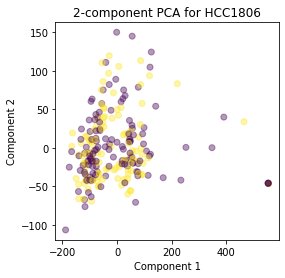

In [125]:
plt.figure(figsize=(4, 4))
plt.scatter(red_X1[0], red_X1[1], alpha=0.4, c=y_hcc)
plt.title("2-component PCA for HCC1806")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

We can already see a slight separability between the two components which could be useful when developing models which make use of it (such as, but not limited to, SVMs).

#### Multidimensional Scaling (MDS)
reduces dimensionality while trying to preserve
the distances between the instances.

In [126]:
mds = MDS(n_components=2, random_state=42, normalized_stress='auto')
X1_reduced_mds = mds.fit_transform(X1)

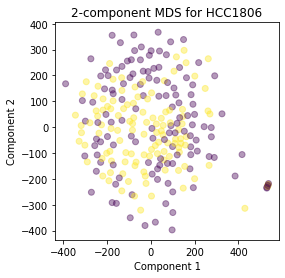

In [127]:
plt.figure(figsize=(4, 4))
plt.scatter(X1_reduced_mds[:, 0], X1_reduced_mds[:, 1], alpha=0.4, c=y_hcc)
plt.title("2-component MDS for HCC1806")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

#### Isomap 
creates a graph by connecting each instance to its nearest neighbors, then
reduces dimensionality while trying to preserve the geodesic distances between
the instances.

In [128]:
isomap = Isomap(n_components=2)
X1_reduced_isomap = isomap.fit_transform(X1)

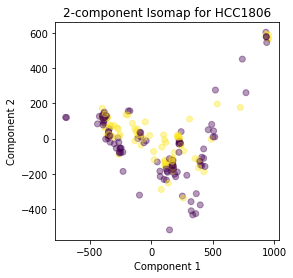

In [129]:
plt.figure(figsize=(4, 4))
plt.scatter(X1_reduced_isomap[:, 0], X1_reduced_isomap[:, 1], alpha=0.4, c=y_hcc)
plt.title("2-component Isomap for HCC1806")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

#### t-Distributed Stochastic Neighbor Embedding (t-SNE) 
reduces dimensionality
while trying to keep similar instances close and dissimilar instances apart. It is
mostly used for visualization, in particular to visualize clusters of instances in
high-dimensional space (e.g., to visualize the MNIST images in 2D).

In [130]:
tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
X1_reduced_tsne = tsne.fit_transform(X1)

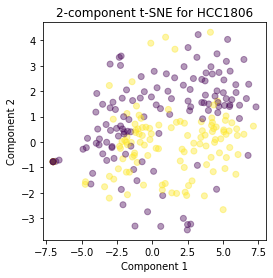

In [131]:
plt.figure(figsize=(4, 4))
plt.scatter(X1_reduced_tsne[:, 0], X1_reduced_tsne[:, 1], alpha=0.4, c=y_hcc)
plt.title("2-component t-SNE for HCC1806")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

### MCF7

#### PCA

In [132]:
#Running PCA on the mcf dataframe
pca = PCA(n_components=2)
pca.fit(X2)

print(f"The 2-component explained variance is divided as follows: {pca.explained_variance_ratio_}")
print(f"It accounts for a total of: {round(sum(pca.explained_variance_ratio_)*100,2)}% of the total variance")
red_X2 = pd.DataFrame(pca.transform(X2))
display(red_X2)


The 2-component explained variance is divided as follows: [0.36394716 0.06297483]
It accounts for a total of: 42.69% of the total variance


,0,1
0,-5.928438,78.977548
1,427.672556,-37.502241
2,27.880764,117.007267
3,328.067999,-33.961445
4,61.607324,-64.918281
...,...,...
378,54.076964,-41.397788
379,-59.399294,-16.836038
380,-65.435513,109.516033
381,-99.577631,96.099985


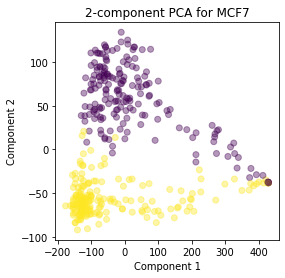

In [133]:
plt.figure(figsize=(4, 4))
plt.scatter(red_X2[0], red_X2[1], alpha=0.4, c=y_mcf)
plt.title("2-component PCA for MCF7")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

Again much like for the HCC1806, there appears to be a certain extent of linear separability.

#### Multidimensional Scaling (MDS)
reduces dimensionality while trying to preserve
the distances between the instances.

In [134]:
mds = MDS(n_components=2, random_state=42, normalized_stress='auto')
X2_reduced_mds = mds.fit_transform(X2)

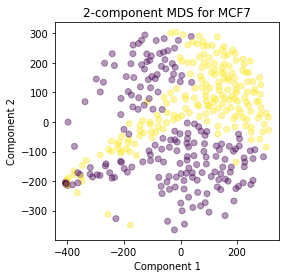

In [135]:
plt.figure(figsize=(4, 4))
plt.scatter(X2_reduced_mds[:, 0], X2_reduced_mds[:, 1], alpha=0.4, c=y_mcf)
plt.title("2-component MDS for MCF7")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

#### Isomap 
creates a graph by connecting each instance to its nearest neighbors, then
reduces dimensionality while trying to preserve the geodesic distances between
the instances.

In [136]:
isomap = Isomap(n_components=2)
X2_reduced_isomap = isomap.fit_transform(X2)

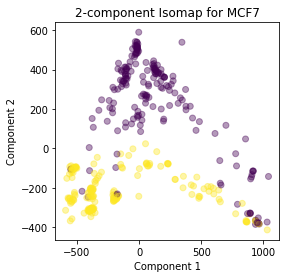

In [137]:
plt.figure(figsize=(4, 4))
plt.scatter(X2_reduced_isomap[:, 0], X2_reduced_isomap[:, 1], alpha=0.4, c=y_mcf)
plt.title("2-component Isomap for MCF7")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

#### t-Distributed Stochastic Neighbor Embedding (t-SNE) 
reduces dimensionality
while trying to keep similar instances close and dissimilar instances apart. It is
mostly used for visualization, in particular to visualize clusters of instances in
high-dimensional space (e.g., to visualize the MNIST images in 2D).

In [138]:
tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
X2_reduced_tsne = tsne.fit_transform(X2)

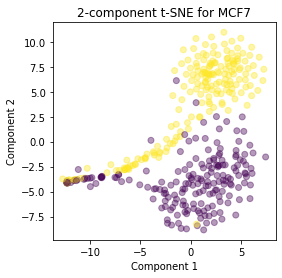

In [139]:
plt.figure(figsize=(4, 4))
plt.scatter(X2_reduced_tsne[:, 0], X2_reduced_tsne[:, 1], alpha=0.4, c=y_mcf)
plt.title("2-component t-SNE for MCF7")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

### Understanding the results

After having carefully analysed and plotted various dimensionality reductions on both the HCC1806 and MCF7 dataframes we can see how a 2 component division of the data actually renders it linearly separable in some instances (such as PCA for MCF7). Nonetheless the relatively low explained variance from the PCA might hinder its performance and hence reduce its potential in model implementation. The 3 component PCA was not displayed as the increase in explained variance was again not as beneficial as one might hope. 
However, this poses the question of how the PCA might have performed on the original data (it might be the case that all the transformations applied to it might have actually caused the PCA to perform worse).

### PCA on the original dataframes

In [140]:
hcc_smarts_df = add_label_T(unfilt_hcc_smarts)
mcf_smarts_df = add_label_T(unfilt_mcf_smarts)

X1 = hcc_smarts_df.loc[:,hcc_smarts_df.columns!='label']
X2 = mcf_smarts_df.loc[:,mcf_smarts_df.columns!='label']
y_hcc = hcc_smarts_df['label']
y_mcf = mcf_smarts_df['label']
display(X1)
display(X2)

,WASH7P,CICP27,DDX11L17,WASH9P,OR4F29,MTND1P23,MTND2P28,MTCO1P12,MTCO2P12,MTATP8P1,...,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP,MAFIP
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam,0,0,0,0,2,250,54,1740,6,1,...,17,5,15,3852,900,22,4208,26,66,0
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam,0,0,0,0,0,424,100,2340,5,1,...,49,29,36,7457,1439,43,6491,62,71,4
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam,0,0,0,0,0,11,0,22,0,0,...,0,0,0,93,12,0,25,0,1,0
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam,0,0,0,0,0,63,16,1020,3,0,...,43,17,8,1479,234,0,4819,11,3,7
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam,0,0,0,0,0,27,3,303,0,0,...,0,0,3,303,33,0,310,4,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam,0,0,0,1,0,146,47,961,1,0,...,25,17,11,2926,423,26,3719,42,48,3
output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam,0,0,0,0,0,37,6,372,0,0,...,2,1,3,688,114,1,984,1,18,0
output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam,0,0,0,1,0,83,30,1128,4,0,...,9,6,23,2999,486,4,2256,15,36,2
output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam,0,0,0,0,0,47,7,258,1,0,...,2,3,3,611,75,4,981,6,8,1


,WASH7P,MIR6859-1,WASH9P,OR4F29,MTND1P23,MTND2P28,MTCO1P12,MTCO2P12,MTATP8P1,MTATP6P1,...,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP,MAFIP
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam,0,0,1,0,0,2,2,0,0,29,...,0,0,0,505,147,4,270,0,5,8
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,1,0,0,0
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam,0,0,0,0,0,1,1,1,0,12,...,0,0,0,1,0,0,76,0,0,0
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam,0,0,0,0,0,0,0,0,0,7,...,1,0,0,44,8,0,66,0,1,0
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam,0,0,0,0,0,0,0,0,0,68,...,0,0,0,237,31,3,727,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam,0,0,0,0,0,0,1,0,0,49,...,0,0,1,341,46,1,570,0,0,0
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam,0,0,1,0,0,2,5,5,0,370,...,0,0,2,1612,215,6,3477,3,7,6
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam,1,0,1,0,0,7,0,0,0,33,...,0,0,0,62,20,0,349,0,2,0
output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam,0,0,4,1,0,29,4,0,0,228,...,3,0,2,1934,575,7,2184,2,28,1


The 2-component explained variance is divided as follows: [0.48773783 0.11690897]
It accounts for a total of: 60.46% of the total variance


,0,1
0,8508.231537,6572.525597
1,66982.567454,-34314.867509
2,-56024.107315,7548.406873
3,53124.609960,-43416.533952
4,-35092.681963,10995.846100
...,...,...
238,-5887.971793,-14855.195558
239,-43546.752863,776.491786
240,19297.497843,-11357.496112
241,-40565.267959,2338.182898


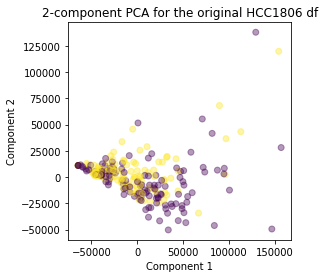

In [141]:
#Running PCA on the hcc dataframe
pca = PCA(n_components=2)
pca.fit(X1)

print(f"The 2-component explained variance is divided as follows: {pca.explained_variance_ratio_}")
print(f"It accounts for a total of: {round(sum(pca.explained_variance_ratio_)*100,2)}% of the total variance")
red_X1 = pd.DataFrame(pca.transform(X1))
display(red_X1)
plt.figure(figsize=(4, 4))
plt.scatter(red_X1[0], red_X1[1], alpha=0.4, c=y_hcc)
plt.title("2-component PCA for the original HCC1806 df")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

The 2-component explained variance is divided as follows: [0.52781575 0.17881458]
It accounts for a total of: 70.66% of the total variance


,0,1
0,13131.081856,-12716.489155
1,-47422.754025,-24042.707166
2,94682.412774,-3885.918848
3,-46804.508372,-23673.963171
4,-37054.766246,-10017.024374
...,...,...
378,-30423.989675,258.437947
379,-5965.250695,102.228087
380,4265.961618,-21684.709634
381,41724.822448,-23590.325613


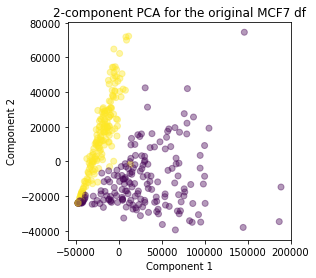

In [142]:
#Running PCA on the mcf dataframe
pca = PCA(n_components=2)
pca.fit(X2)

print(f"The 2-component explained variance is divided as follows: {pca.explained_variance_ratio_}")
print(f"It accounts for a total of: {round(sum(pca.explained_variance_ratio_)*100,2)}% of the total variance")
red_X2 = pd.DataFrame(pca.transform(X2))
display(red_X2)
plt.figure(figsize=(4, 4))
plt.scatter(red_X2[0], red_X2[1], alpha=0.4, c=y_mcf)
plt.title("2-component PCA for the original MCF7 df")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

Indeed, it does seem that although like in the log transformed data there is some linear separability, this PCA actually holds a higher amount of explained variance. Therefore, when deciding to use PCA in the model implementation (if it seems reasonable to do so), it might make more sense to use it on the unfiltered data directly.

## Models

To build our models we use the filtered and normalised data, as it is easier to build better models on preprocessed data, than on raw data.

### SmartSeq MCF7

In this section we fit a classifier for the dataset SmartSeq MCF7. From our preliminary analysis it seemed that a linear model could do a very good job, thus we try Logistic Regression. Linear models, not being complex generalize well to new data, without risking overfitting; moreover, they give us a great result interpretability.

In [143]:
df = pd.read_csv("data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt", sep=" ")
df = add_label_T(df, dropname=True)
df

,CYP1B1,CYP1B1-AS1,CYP1A1,NDRG1,DDIT4,PFKFB3,HK2,AREG,MYBL2,ADM,...,DNAI7,MAFG,LZTR1,BCO2,GRIK5,SLC25A27,DENND5A,CDK5R1,FAM13A-AS1,label
0,343,140,0,0,386,75,0,0,476,0,...,0,17,59,0,0,0,51,0,0,1
1,131,59,0,1,289,42,0,856,1586,0,...,0,1,25,0,0,0,34,0,0,1
2,452,203,0,0,0,0,0,0,775,0,...,0,23,0,0,0,0,0,0,0,1
3,27,7,0,0,288,214,15,242,1191,0,...,0,3,10,0,0,0,4,0,0,1
4,5817,2669,0,654,2484,1603,748,436,0,0,...,0,63,0,0,0,0,60,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,196,102,1,243,266,278,78,1,199,0,...,0,1,0,0,0,0,45,19,0,1
246,504,238,0,62,417,932,275,0,33,0,...,0,0,0,0,0,0,0,0,0,1
247,34565,13717,11274,1263,4256,5663,701,0,0,0,...,0,45,0,0,0,0,140,0,32,0
248,20024,7835,563,925,12733,2187,1141,0,20,81,...,0,57,8,0,0,0,7,0,11,0


Given our high-dimensionality context, we use the L1 penanlty in our logistic regression in order to induce sparsity in the model, thus finding the responsible genes.

In [144]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("label", axis=1), df["label"], test_size=0.2, random_state=42)

We try to find the best value for C, the inverse of the regularization coefficient.

In [145]:
clf = LogisticRegression(penalty="l1", solver="liblinear", random_state=42)
param_grid = {
    "C": [10**x for x in range(-3, 3)]
}

grid_search = GridSearchCV(clf, param_grid)
grid_search.fit(X_train, y_train)

print("Best value of C:", grid_search.best_params_["C"])
print("Cross validation mean accuracy:", grid_search.best_score_)

Best value of C: 0.01
Cross validation mean accuracy: 1.0


C=0.1 scores perfectly on the cross validation, thus we are going to test it.

In [146]:
log_reg = LogisticRegression(penalty="l1", C=0.1, solver="liblinear", random_state=42)
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

1.0

Again a perfect score, we can conclude that our model is very good. Now let's see how many, and which, genes influence the label.

In [147]:
def relevant_genes(feature_names, coef):
    non_zero_coef = list()
    for i, c in enumerate(coef):
        if abs(c) > 0:
            non_zero_coef.append(feature_names[i])
    non_zero_coef.sort()

    print("Number of non zero coeffiecients:", len(non_zero_coef))
    print("Relevant genes:", non_zero_coef)

In [148]:
feature_names = df.columns.tolist()
coef = log_reg.coef_.tolist()[0]

relevant_genes(feature_names, coef)

Number of non zero coeffiecients: 36
Relevant genes: ['ACTG1', 'ALDOA', 'ATP1A1', 'BEST1', 'CEACAM5', 'CYP1B1', 'DDIT4', 'DDX5', 'DHCR7', 'DSP', 'EMP2', 'FLNA', 'FTH1', 'FTL', 'GAPDH', 'GATA3', 'GPI', 'HSPB1', 'LDHA', 'LMNA', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND4', 'MT-RNR2', 'NME1-NME2', 'NR4A1', 'PGK1', 'SLC9A3R1', 'SULF2', 'TMSB10', 'TMSB4X', 'TUBA1B', 'UBB', 'XBP1']


We can very well see how the L1 penalty induced sparsity in the model: out of 3000 genes, only 36 are being used by the model.

### SmartSeq HCC1806

Again, we try Logistic Regression and see how it performs.

In [149]:
df = pd.read_csv("data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt", sep=" ")
df = add_label_T(df, dropname=True)
df

,DDIT4,ANGPTL4,CALML5,KRT14,CCNB1,IGFBP3,AKR1C2,KRT6A,NDRG1,KRT4,...,ZYG11A,NRG1,RBMS3,VCPIP1,LINC02693,OR8B9P,NEAT1,ZDHHC23,ODAD2,label
0,0,48,0,321,298,82,6250,634,0,0,...,10,136,0,0,29,0,29,0,0,1
1,8739,2101,55,96,1824,1938,62,0,522,413,...,0,264,0,134,68,0,213,0,0,0
2,13098,14032,0,0,1616,247,430,907,348,0,...,0,38,0,0,0,0,92,0,0,0
3,2880,356,0,6211,3,3430,79,1953,592,176,...,0,16,0,4,1,0,1,0,0,0
4,7777,5661,4383,0,145,4618,246,85,206,0,...,1,25,0,0,0,0,128,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,79,5,0,2098,554,99,798,4211,64,0,...,0,264,0,10,34,0,24,0,0,1
178,167,1,0,27,3585,134,3,596,11,0,...,0,120,25,0,53,0,177,53,0,1
179,10186,3147,0,149,1012,111,716,617,744,0,...,0,55,0,157,43,0,113,0,0,0
180,238,41,2867,814,2207,297,1023,2879,1,0,...,0,42,0,26,0,0,13,5,0,1


In [150]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("label", axis=1), df["label"], test_size=0.2, random_state=42)

This time we add also the L2 penalty in our grid search, to see if it performs better.

In [151]:
clf = LogisticRegression(solver="liblinear", random_state=42)
param_grid = {
    "penalty": ["l1", "l2"],
    "C": [10**x for x in range(-3, 3)]
}

grid_search = GridSearchCV(clf, param_grid)
grid_search.fit(X_train, y_train)

print("Best parameters", grid_search.best_params_)
print("Cross validation mean accuracy:", grid_search.best_score_)

Best parameters {'C': 1, 'penalty': 'l1'}
Cross validation mean accuracy: 0.993103448275862


The score is not perfect, but almost; we can try to zoom in the range 0.1-2 to see if we find a better value for C.

In [152]:
clf = LogisticRegression(penalty="l1", solver="liblinear", random_state=42)
param_grid = {
    "C": np.arange(0.1, 2, 0.1)
}

grid_search = GridSearchCV(clf, param_grid)
grid_search.fit(X_train, y_train)

print("Best value of C:", grid_search.best_params_["C"])
print("Cross validation mean accuracy:", grid_search.best_score_)

Best value of C: 1.2000000000000002
Cross validation mean accuracy: 1.0


With C=1.2 the score on the cross validation is perfect, now we test our model on the test set (this dataset contains only 182 samples, so we do not have a validation set).

In [153]:
log_reg = LogisticRegression(penalty="l1", C=1.2, solver="liblinear", random_state=42)
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

1.0

We got a perfect score, so we can stick to this linear model, without the need to explore more complex models. Again we can see the genes whose associated coefficient in the regression is not 0; in this case C is larger, and so the regularization milder, hence the model less sparse.

In [154]:
feature_names = df.columns.tolist()
coef = log_reg.coef_.tolist()[0]

relevant_genes(feature_names, coef)

Number of non zero coeffiecients: 169
Relevant genes: ['ACTG1', 'ACTN1', 'AHNAK', 'AKR1C2', 'AKR1C3', 'ALDOA', 'ALDOC', 'ANGPTL4', 'ANXA1', 'ARRDC3', 'B2M', 'BEST1', 'BHLHE40', 'BIRC5', 'BLCAP', 'BNIP3', 'BNIP3L', 'BRD2', 'C4orf3', 'CALM2', 'CAV1', 'CCNB1', 'CD44', 'CD59', 'CDC20', 'CEACAM5', 'COL17A1', 'CSTB', 'CTSB', 'DDIT4', 'DKK1', 'DUSP1', 'EGLN3', 'EPHA2', 'ERO1A', 'EZR', 'F3', 'FAM162A', 'FAM83A', 'FGFBP1', 'FLNA', 'FOS', 'FOSL1', 'FOSL2', 'FSCN1', 'FTH1', 'FTL', 'G0S2', 'GLUL', 'GPI', 'GPRC5A', 'GPX2', 'GRN', 'H1-0', 'H2AZ1', 'H4C3', 'HLA-A', 'HMGA1', 'HSP90AA1', 'HSP90B1', 'HSPA5', 'HSPA8', 'IDI1', 'IGFBP3', 'INSIG1', 'ITGA6', 'JUP', 'KCTD11', 'KDM5B', 'KPNA2', 'KRT13', 'KRT14', 'KRT17', 'KRT18', 'KRT19', 'KRT4', 'KRT5', 'KRT6A', 'KRT7', 'KRT8', 'LAMA3', 'LAMB3', 'LAMC1', 'LAMC2', 'LDHA', 'LDHB', 'LMNA', 'MAL2', 'MALAT1', 'MCM3', 'MIF', 'MIF-AS1', 'MMP1', 'MRNIP', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND4', 'MT-ND4L', 'MT-ND5', 'MT-RNR1', 'MT-RNR2', 'MT2A', 'MYBL2', 'NDRG1', 'NEU1

Regarding SmartSeq, we used Logistic Regression in both cell types, however the parameters used are slightly different. In both occasion we used the L1 penalty, to induce sparsity in the model, and find the most relevant genes. However, for MCF7 the regularization used was one order of magnitude stronger, and thus we ended up with a smaller, and simpler, model. On HCC1806 it wasn't possible to achieve a perfect score with such a simple model, so we had to reduce the regularization and allow for a more complex model.

As specified at the start of this section, we used the filtered and normalised data to build our models, but what if we used the unfiltered data, or the filtered but not normalised data? We are going to try the model we selected earlier on these datasets, and see how large the difference in performance is. We use the SmartSeq MCF7 dataset.

In [155]:
df = pd.read_csv("data/SmartSeq/MCF7_SmartS_Unfiltered_Data.txt", sep=" ")
df = add_label_T(df, dropname=True)
df

,WASH7P,MIR6859-1,WASH9P,OR4F29,MTND1P23,MTND2P28,MTCO1P12,MTCO2P12,MTATP8P1,MTATP6P1,...,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP,MAFIP,label
0,0,0,1,0,0,2,2,0,0,29,...,0,0,505,147,4,270,0,5,8,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
2,0,0,0,0,0,1,1,1,0,12,...,0,0,1,0,0,76,0,0,0,0
3,0,0,0,0,0,0,0,0,0,7,...,0,0,44,8,0,66,0,1,0,1
4,0,0,0,0,0,0,0,0,0,68,...,0,0,237,31,3,727,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,0,0,0,0,0,0,1,0,0,49,...,0,1,341,46,1,570,0,0,0,1
379,0,0,1,0,0,2,5,5,0,370,...,0,2,1612,215,6,3477,3,7,6,1
380,1,0,1,0,0,7,0,0,0,33,...,0,0,62,20,0,349,0,2,0,0
381,0,0,4,1,0,29,4,0,0,228,...,0,2,1934,575,7,2184,2,28,1,0


For the unfilted data we have almost 23000 genes, a huge number!

In [156]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("label", axis=1), df["label"], test_size=0.2, random_state=42)

In [157]:
log_reg = LogisticRegression(penalty="l1", C=0.1, solver="liblinear", random_state=42)
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.987012987012987

The score achieved with the model selected on the filtered and normalised dataset is still very good, now let's see how many of the 23000 genes our model uses.

In [158]:
feature_names = df.columns.tolist()
coef = log_reg.coef_.tolist()[0]

relevant_genes(feature_names, coef)

Number of non zero coeffiecients: 65
Relevant genes: ['ACTB', 'ACTG1', 'ALDOA', 'ALG12', 'BAMBI', 'BCAS3', 'BEST1', 'CDH1', 'CEACAM5', 'CFL1', 'COPE', 'COX6C', 'CTSD', 'CYP1A1', 'CYP1B1', 'CYP1B1-AS1', 'DDIT4', 'DHCR7', 'DOT1L', 'EMP2', 'ENO1', 'FLNA', 'FTH1', 'GAPDH', 'GATA3', 'GFRA1', 'GNAS', 'GPI', 'H3-3B', 'HSPA8', 'KRT18', 'KRT19', 'KRT8', 'LY6E', 'MALAT1', 'MIF', 'MIF-AS1', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-RNR2', 'NME1-NME2', 'NR4A1', 'PFKFB3', 'PGK1', 'PKM', 'PPP1CA', 'PSMA7', 'RPL8', 'SCD', 'SERF2', 'SLC2A1', 'SLC39A6', 'SLC9A3R1', 'SQSTM1', 'STARD10', 'SULF2', 'TFF3', 'TMSB10', 'TMSB4X', 'TUBA1B', 'TUBB4B', 'UBB', 'XBP1']


The model needs only 65 genes to get an accuracy of 98.7%. This is not perfect as on the preprocessed data, but still good. Now let's see if the situation changes with the filtered data.

In [159]:
df = pd.read_csv("data/SmartSeq/MCF7_SmartS_Filtered_Data.txt", sep=" ")
df = add_label_T(df, dropname=True)
df

,WASH7P,MIR6859-1,WASH9P,OR4F29,MTND1P23,MTND2P28,MTCO1P12,MTCO2P12,MTATP8P1,MTATP6P1,...,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP,MAFIP,label
0,0,0,1,0,0,2,2,0,0,29,...,0,0,505,147,4,270,0,5,8,0
1,0,0,0,0,0,1,1,1,0,12,...,0,0,1,0,0,76,0,0,0,0
2,0,0,0,0,0,0,0,0,0,68,...,0,0,237,31,3,727,0,0,0,1
3,0,0,1,0,0,1,3,0,0,203,...,0,0,894,113,3,2717,1,1,0,1
4,0,0,10,0,0,3,10,1,0,691,...,0,3,1279,131,0,9326,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,0,0,0,0,0,0,1,0,0,49,...,0,1,341,46,1,570,0,0,0,1
309,0,0,1,0,0,2,5,5,0,370,...,0,2,1612,215,6,3477,3,7,6,1
310,1,0,1,0,0,7,0,0,0,33,...,0,0,62,20,0,349,0,2,0,0
311,0,0,4,1,0,29,4,0,0,228,...,0,2,1934,575,7,2184,2,28,1,0


In [160]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("label", axis=1), df["label"], test_size=0.2, random_state=42)

In [161]:
log_reg = LogisticRegression(penalty="l1", C=0.1, solver="liblinear", random_state=42)
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.9841269841269841

In [162]:
feature_names = df.columns.tolist()
coef = log_reg.coef_.tolist()[0]

relevant_genes(feature_names, coef)

Number of non zero coeffiecients: 50
Relevant genes: ['ACTB', 'ACTG1', 'ALDOA', 'ATP1A1', 'ATP5F1B', 'BEST1', 'BSG', 'CFL1', 'COPE', 'CTSD', 'CYP1B1', 'CYP1B1-AS1', 'DDIT4', 'DYNC2I2', 'ENO1', 'FLNA', 'FTH1', 'GAPDH', 'GATA3', 'GNAS', 'GPI', 'GSTM3', 'HSPB1', 'KRT18', 'KRT19', 'KRT8', 'KRT80', 'KRT81', 'LDHA', 'MCM7', 'MIF', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND4', 'MYL6', 'NME1-NME2', 'PFKFB3', 'PGK1', 'PKM', 'SLC2A1', 'SLC9A3R1', 'SULF2', 'TFF1', 'TK1', 'TMSB10', 'TUBA1B', 'TUBB4B', 'UBC']


The situation did not improve. This would lead to believe that the normalisation is crucial for the performance of the model; however we have to note that the filtered and normalised dataset is further filtered and includes only 3000 genes, as opposed to the almost 19000 present in the only filtered dataset. To see if the normalisation has some influence, we can shrink the unfiltered dataset to include only the 36 genes used by our model on the filtered and normalised dataset, and see if the performance differs.

In [163]:
genes = ['ACTG1', 'ALDOA', 'ATP1A1', 'BEST1', 'CEACAM5', 'CYP1B1', 'DDIT4', 'DDX5', 'DHCR7', 'DSP', 'EMP2', 'FLNA', 'FTH1', 'FTL', 'GAPDH', 'GATA3', 'GPI', 'HSPB1', 'LDHA', 'LMNA', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB', 'MT-ND4', 'MT-RNR2', 'NME1-NME2', 'NR4A1', 'PGK1', 'SLC9A3R1', 'SULF2', 'TMSB10', 'TMSB4X', 'TUBA1B', 'UBB', 'XBP1']

In [164]:
df = pd.read_csv("data/SmartSeq/MCF7_SmartS_Unfiltered_Data.txt", sep=" ")
df = add_label_T(df, dropname=True)
df

,WASH7P,MIR6859-1,WASH9P,OR4F29,MTND1P23,MTND2P28,MTCO1P12,MTCO2P12,MTATP8P1,MTATP6P1,...,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP,MAFIP,label
0,0,0,1,0,0,2,2,0,0,29,...,0,0,505,147,4,270,0,5,8,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
2,0,0,0,0,0,1,1,1,0,12,...,0,0,1,0,0,76,0,0,0,0
3,0,0,0,0,0,0,0,0,0,7,...,0,0,44,8,0,66,0,1,0,1
4,0,0,0,0,0,0,0,0,0,68,...,0,0,237,31,3,727,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,0,0,0,0,0,0,1,0,0,49,...,0,1,341,46,1,570,0,0,0,1
379,0,0,1,0,0,2,5,5,0,370,...,0,2,1612,215,6,3477,3,7,6,1
380,1,0,1,0,0,7,0,0,0,33,...,0,0,62,20,0,349,0,2,0,0
381,0,0,4,1,0,29,4,0,0,228,...,0,2,1934,575,7,2184,2,28,1,0


In [165]:
X, y = df[genes], df["label"]

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [167]:
log_reg = LogisticRegression(penalty="l1", C=0.1, solver="liblinear", random_state=42)
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

1.0

On this exremely filtered dataset the score is perfect, thus the normalisation is not crucial, and filtering is more important. While Logistic Regression with the L1 penalty already selects features on its own, having a filtered dataset definitely helps the process, and leads to better models.

### DropSeq MCF7

In [168]:
df = pd.read_csv("data/DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt", sep=" ")
df = add_label_T(df, dropname=True)
df

,MALAT1,MT-RNR2,NEAT1,H1-5,TFF1,MT-RNR1,H4C3,GDF15,KRT81,MT-CO3,...,SKIDA1,MICALL1,RARG,MYO1F,BRWD1-AS2,RPS19BP1,AUNIP,TNK2,SUDS3,label
0,1,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,3,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,6,2,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,4,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21621,0,0,0,0,3,0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21622,1,0,0,0,4,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
21623,0,0,0,1,2,0,4,0,0,0,...,0,0,0,0,0,0,0,0,1,0
21624,0,0,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [169]:
X = df.drop("label", axis=1)
y = df["label"]

In this case we have a lot of data at our disposal, thus we will split our dataset in training, validation, and testing; 60% 20% 20%.

In [170]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

Again, we started with Logistic Regression, and found that the best parameters are the L2 penalty with C=0.1, however the score of the grid search on the train dataset is 0.98, so not perfect, we now try on the validation set.

In [171]:
clf = LogisticRegression(penalty="l2", C=0.1, solver="liblinear", random_state=42)
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.9798843930635838

Since the score can be improved, we will try different models, and then select the best one. To avoid making the notebook too heavy we will report here the models with the parameters already tuned, after having used a grid search on the train dataset.

Now we try a Support Vector Machine, for which the parameters we found as best are the default one, except for C=10.

In [172]:
clf = SVC(C=10)
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.979421965317919

We can see that this model is definetely slower during training than the Logistic Regression, and scored sligthly worse.

Now we try LightGBM, a high-performance machine learning library designed for analyzing large-scale datasets efficiently, offering fast training speed and accurate predictions through gradient boosting algorithms.

In [173]:
clf = LGBMClassifier(num_leaves=20, n_estimators=10000, max_depth=30, reg_lambda=0.1)
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.9835838150289017

This model performed better than the other two, the training time is not as fast as Logistic Regression, but only due to the high number of estimators (n_estimator); reducing it to 1000 would make the training much faster, but it would lead to a little loss in accuracy.

We tried also other models, but we couldn't find any that outperformed LGBMClassfier on the validation set, therefore we can test it.

In [174]:
clf.score(X_test, y_test)

0.9845122515025427

The score on the test set is satisfying, so we are going to use this model for our predictions.

### DropSeq HCC1806

In [175]:
df = pd.read_csv("data/DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt", sep=" ")
df = add_label_T(df, dropname=True)
df

,H1-5,MALAT1,MT-RNR2,ARVCF,BCYRN1,ATXN7L2,IGFBP3,H1-3,CTIF,RNF123,...,CDKN3,DLD,PMPCA,ZNF165,SCCPDH,NTAN1,CLIP2,DUSP23,ZNF682,label
0,2,3,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,3,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,5,2,0,0,1,0,1,3,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14677,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14678,0,4,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14679,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14680,3,3,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [176]:
X = df.drop("label", axis=1)
y = df["label"]
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

We start the model selection by trying the two models that have had most success so far: Logistic Regression and LGMBClassifier.

In [177]:
clf = LogisticRegression(solver="liblinear")
param_grid = {
    "penalty": ["l1", "l2"],
    "C": [10**x for x in range(-1, 1)]
}
grid_search = GridSearchCV(clf, param_grid)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'C': 0.1, 'penalty': 'l2'}
Best score: 0.9508402833236971


In [178]:
clf = LogisticRegression(penalty="l2", C=0.1, solver="liblinear")
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.95471569628873

On this dataset the score we are getting is lower than for the previous ones, let's see what we get with the model we selected for MCF7.

In [179]:
clf  = LGBMClassifier(num_leaves=20, n_estimators=10000, max_depth=30, reg_lambda=0.1)
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.9632277834525026

Again, better than Logistic Regression. We carefully analyzed other models, but we couldn't find anything that performed better than LGBMClassifier, so we test it.

In [180]:
clf.score(X_test, y_test)

0.9625468164794008

The score is similar, so we are going to use it for the predictions.